**Problem Statement**

- Salary prediction of nurses
- part-time/non-regular jobs are out of scope, target nurses are
    - `REGISTERED NURSE`,
    - `LICENSED VOCATIONAL NURSE`
    - `NURSING ASSISTANT`
    - `NURSE MANAGER`
    - `PUBLIC HEALTH NURSE`
- only nurses who work more than 5 years

# Import

In [1]:
#data stuff
import pandas as pd
import numpy as np

#Modelling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

#other
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
# from pythainlp import word_tokenize

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Load raw data

- including not only nurses but also other jobs 
- uppercase all names and job titles 

In [2]:
rawdata = pd.read_csv('./data/san-francisco-payroll_2011-2019.csv',low_memory=False)
rawdata['Employee Name'] = rawdata['Employee Name'].apply(lambda x: x.upper())
rawdata['Job Title'] = rawdata['Job Title'].apply(lambda x: x.upper())
rawdata

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,JANET LEE MILLER,COURT STAFF ATTORNEY II,0.0,0.0,0.0,0.0,0.00,0.00,2019,PT
1,GARY MAR,ELECTRICAL TRANSIT SYSTEM MECH,97354.53,6996.5,2380.0,38855.9,106731.03,145586.93,2019,FT
2,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
3,KRISTIAN C SMOCK,"STATIONARY ENG, SEWAGE PLANT",106816.03,0.0,0.0,38729.65,106816.03,145545.68,2019,FT
4,YUN Y CHANG,PHARMACY TECHNICIAN,94039.13,14947.99,1241.69,35330.26,110228.81,145559.07,2019,FT
...,...,...,...,...,...,...,...,...,...,...
357402,HOWARD CHUCK,CUSTODIAN,46106.73,890.49,4839.07,Not Provided,51836.29,51836.29,2011,NaN
357403,BING KEUNG MAK,CUSTODIAN,48472.4,1972.35,1390.5,Not Provided,51835.25,51835.25,2011,NaN
357404,QIN MING ZHU,CUSTODIAN,46046.29,1853.97,3934.44,Not Provided,51834.70,51834.70,2011,NaN
357405,JOSE ALONZO,CUSTODIAN,47798.87,0.0,4032.55,Not Provided,51831.42,51831.42,2011,NaN


# filter only target nurses

In [3]:
NURSES = ['REGISTERED NURSE',
'LICENSED VOCATIONAL NURSE',
'NURSING ASSISTANT',
'NURSE MANAGER',
'PUBLIC HEALTH NURSE']

data = rawdata[rawdata['Job Title'].isin(NURSES)].reset_index(drop=True)
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,80359.21,32594.24,250.0,32412.48,113203.45,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,80322.5,24657.58,6328.96,33617.75,111309.04,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,103416.69,0.0,499.97,41061.6,103916.66,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,92256.88,13042.34,12087.06,28001.22,117386.28,145387.50,2019,PT
...,...,...,...,...,...,...,...,...,...,...
16497,NERIZA SAMALA,LICENSED VOCATIONAL NURSE,49883.47,0.0,484.88,Not Provided,50368.35,50368.35,2011,NaN
16498,DAWA SUBHAR,REGISTERED NURSE,48489.15,0.0,1862.64,Not Provided,50351.79,50351.79,2011,NaN
16499,PETER SCHULZE,REGISTERED NURSE,44727.19,567.18,4647.31,Not Provided,49941.68,49941.68,2011,NaN
16500,MICHAEL ENWEREUZO SR,LICENSED VOCATIONAL NURSE,43183.6,5962.24,3660.48,Not Provided,52806.32,52806.32,2011,NaN


In [4]:
## count of each nurse
data['Job Title'].value_counts()

REGISTERED NURSE             11939
LICENSED VOCATIONAL NURSE     2013
NURSING ASSISTANT             1228
NURSE MANAGER                  799
PUBLIC HEALTH NURSE            523
Name: Job Title, dtype: int64

In [5]:
## count of each year
data['Year'].value_counts()

2019    2032
2018    1946
2017    1908
2016    1862
2015    1802
2013    1762
2012    1758
2014    1754
2011    1678
Name: Year, dtype: int64

## check duplicated employee name

In [6]:
grouped = data.groupby(['Employee Name', 'Year']).count()['Job Title']
grouped

Employee Name        Year
AACE WU              2018    1
                     2019    1
AARON CRAMER         2011    1
                     2012    1
AARON LY             2015    1
                            ..
ZOSIMA P PANGILINAN  2017    1
                     2018    1
                     2019    1
ZOSIMA PANGILINAN    2011    1
                     2012    1
Name: Job Title, Length: 16497, dtype: int64

In [7]:
grouped[grouped > 1]

Employee Name        Year
MARGARITA HERRERA    2012    2
MARGARITA L HERRERA  2017    2
MARIA CRUZ           2012    2
NANCY KRAUSS         2012    2
XING C CUI           2017    2
Name: Job Title, dtype: int64

- `MARGARITA HERRERA` and `MARGARITA L HERRERA` may be identical

In [8]:
data[data['Employee Name'] == 'MARGARITA HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
14454,MARGARITA HERRERA,REGISTERED NURSE,17973.09,80.08,21.36,4245.6,18074.53,22320.13,2012,NaN
14732,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50178.68,0.0,350.0,18195.87,50528.68,68724.55,2012,NaN
16245,MARGARITA HERRERA,PUBLIC HEALTH NURSE,1977.5,0.0,0.0,Not Provided,1977.50,1977.50,2011,NaN


In [9]:
data[data['Employee Name'] == 'MARGARITA L HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
1674,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,22808.0,0.0,250.0,4894.82,23058.00,27952.82,2019,PT
3624,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,20828.18,0.0,0.0,4117.76,20828.18,24945.94,2018,PT
5637,MARGARITA L HERRERA,REGISTERED NURSE,0.0,0.0,0.0,903.92,0.00,903.92,2017,PT
5823,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,50169.97,0.0,250.0,10577.52,50419.97,60997.49,2017,PT
7453,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,36995.41,0.00,250.00,12253.61,37245.41,49499.02,2016,NaN
11216,MARGARITA L HERRERA,REGISTERED NURSE,0.0,0.0,45906.8,14396.19,45906.80,60302.99,2014,PT
12771,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,29433.11,0.0,150.0,9754.41,29583.11,39337.52,2013,NaN


In [10]:
## rename `MARGARITA L HERRERA`
data['Employee Name'] = data['Employee Name'].replace('MARGARITA L HERRERA', 'MARGARITA HERRERA')

In [11]:
## replaced
data[data['Employee Name'] == 'MARGARITA HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
1674,MARGARITA HERRERA,PUBLIC HEALTH NURSE,22808.0,0.0,250.0,4894.82,23058.00,27952.82,2019,PT
3624,MARGARITA HERRERA,PUBLIC HEALTH NURSE,20828.18,0.0,0.0,4117.76,20828.18,24945.94,2018,PT
5637,MARGARITA HERRERA,REGISTERED NURSE,0.0,0.0,0.0,903.92,0.00,903.92,2017,PT
5823,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50169.97,0.0,250.0,10577.52,50419.97,60997.49,2017,PT
7453,MARGARITA HERRERA,PUBLIC HEALTH NURSE,36995.41,0.00,250.00,12253.61,37245.41,49499.02,2016,NaN
11216,MARGARITA HERRERA,REGISTERED NURSE,0.0,0.0,45906.8,14396.19,45906.80,60302.99,2014,PT
12771,MARGARITA HERRERA,PUBLIC HEALTH NURSE,29433.11,0.0,150.0,9754.41,29583.11,39337.52,2013,NaN
14454,MARGARITA HERRERA,REGISTERED NURSE,17973.09,80.08,21.36,4245.6,18074.53,22320.13,2012,NaN
14732,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50178.68,0.0,350.0,18195.87,50528.68,68724.55,2012,NaN
16245,MARGARITA HERRERA,PUBLIC HEALTH NURSE,1977.5,0.0,0.0,Not Provided,1977.50,1977.50,2011,NaN


In [12]:
data[data['Employee Name'] == 'NANCY KRAUSS']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
14483,NANCY KRAUSS,LICENSED VOCATIONAL NURSE,26211.6,723.29,441.68,14714.37,27376.57,42090.94,2012,NaN
14556,NANCY KRAUSS,LICENSED VOCATIONAL NURSE,2690.4,0.0,107.64,664.84,2798.04,3462.88,2012,NaN


## filter only those who work more than 1 year

In [13]:
data['Employee Name']=data['Employee Name'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z0-9 ]', '', regex=True)
data['Job Title']=data['Job Title'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z ]', '', regex=True)
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,80359.21,32594.24,250.0,32412.48,113203.45,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,80322.5,24657.58,6328.96,33617.75,111309.04,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,103416.69,0.0,499.97,41061.6,103916.66,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,92256.88,13042.34,12087.06,28001.22,117386.28,145387.50,2019,PT
...,...,...,...,...,...,...,...,...,...,...
16497,NERIZA SAMALA,LICENSED VOCATIONAL NURSE,49883.47,0.0,484.88,Not Provided,50368.35,50368.35,2011,NaN
16498,DAWA SUBHAR,REGISTERED NURSE,48489.15,0.0,1862.64,Not Provided,50351.79,50351.79,2011,NaN
16499,PETER SCHULZE,REGISTERED NURSE,44727.19,567.18,4647.31,Not Provided,49941.68,49941.68,2011,NaN
16500,MICHAEL ENWEREUZO SR,LICENSED VOCATIONAL NURSE,43183.6,5962.24,3660.48,Not Provided,52806.32,52806.32,2011,NaN


In [14]:
df=data[['Employee Name', 'Job Title', 'Total Pay & Benefits', 'Year', 'Status']]
df.columns=['Employee Name', 'Job Title', 'Salary', 'Year', 'Status']
df=df[df['Salary']!=0.0]
df

,Employee Name,Job Title,Salary,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,145387.50,2019,PT
...,...,...,...,...,...
16497,NERIZA SAMALA,LICENSED VOCATIONAL NURSE,50368.35,2011,NaN
16498,DAWA SUBHAR,REGISTERED NURSE,50351.79,2011,NaN
16499,PETER SCHULZE,REGISTERED NURSE,49941.68,2011,NaN
16500,MICHAEL ENWEREUZO SR,LICENSED VOCATIONAL NURSE,52806.32,2011,NaN


In [15]:
start_salary=df.sort_values(by='Year').groupby(by='Employee Name').agg({'Salary':'first', 'Year':'first'}).reset_index()
start_salary.columns=['Employee Name', 'Start Salary', 'Start Year']
start_salary

,Employee Name,Start Salary,Start Year
0,AACE WU,121348.48,2018
1,AARON CRAMER,106385.49,2011
2,AARON LY,54164.61,2015
3,AARON R RAINEY,174662.29,2013
4,AARON RAINEY,78260.44,2011
...,...,...,...
4583,ZEXU FANG,119085.50,2011
4584,ZHALYA GUSEYNOVA,28588.30,2013
4585,ZIYING TAN,64718.51,2019
4586,ZOSIMA P PANGILINAN,107608.78,2013


In [16]:
merge_df=df.merge(start_salary, on ='Employee Name', how='left').sort_values(['Employee Name','Year']).reset_index(drop=True)
merge_df.columns=['Employee Name', 'Job Title', 'End Salary', 'End Year', 'Status','Start Salary', 'Start Year']
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year
0,AACE WU,REGISTERED NURSE,121348.48,2018,PT,121348.48,2018
1,AACE WU,REGISTERED NURSE,86623.20,2019,PT,121348.48,2018
2,AARON CRAMER,REGISTERED NURSE,106385.49,2011,NaN,106385.49,2011
3,AARON CRAMER,REGISTERED NURSE,173747.94,2012,NaN,106385.49,2011
4,AARON LY,REGISTERED NURSE,54164.61,2015,PT,54164.61,2015
...,...,...,...,...,...,...,...
16497,ZOSIMA P PANGILINAN,NURSING ASSISTANT,108824.77,2017,FT,107608.78,2013
16498,ZOSIMA P PANGILINAN,NURSING ASSISTANT,124500.40,2018,FT,107608.78,2013
16499,ZOSIMA P PANGILINAN,NURSING ASSISTANT,79010.87,2019,PT,107608.78,2013
16500,ZOSIMA PANGILINAN,NURSING ASSISTANT,71418.77,2011,NaN,71418.77,2011


In [17]:
merge_df['Total Year']=merge_df['End Year']-merge_df['Start Year']
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year,Total Year
0,AACE WU,REGISTERED NURSE,121348.48,2018,PT,121348.48,2018,0
1,AACE WU,REGISTERED NURSE,86623.20,2019,PT,121348.48,2018,1
2,AARON CRAMER,REGISTERED NURSE,106385.49,2011,NaN,106385.49,2011,0
3,AARON CRAMER,REGISTERED NURSE,173747.94,2012,NaN,106385.49,2011,1
4,AARON LY,REGISTERED NURSE,54164.61,2015,PT,54164.61,2015,0
...,...,...,...,...,...,...,...,...
16497,ZOSIMA P PANGILINAN,NURSING ASSISTANT,108824.77,2017,FT,107608.78,2013,4
16498,ZOSIMA P PANGILINAN,NURSING ASSISTANT,124500.40,2018,FT,107608.78,2013,5
16499,ZOSIMA P PANGILINAN,NURSING ASSISTANT,79010.87,2019,PT,107608.78,2013,6
16500,ZOSIMA PANGILINAN,NURSING ASSISTANT,71418.77,2011,NaN,71418.77,2011,0


In [18]:
merge_df['Increase Percentage']=round((merge_df['End Salary']-merge_df['Start Salary'])/merge_df['Start Salary']*100,2)
merge_df=merge_df[merge_df['Total Year']!=0].reset_index(drop=True)
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year,Total Year,Increase Percentage
0,AACE WU,REGISTERED NURSE,86623.20,2019,PT,121348.48,2018,1,-28.62
1,AARON CRAMER,REGISTERED NURSE,173747.94,2012,NaN,106385.49,2011,1,63.32
2,AARON LY,REGISTERED NURSE,149338.07,2016,NaN,54164.61,2015,1,175.71
3,AARON LY,REGISTERED NURSE,163583.77,2017,FT,54164.61,2015,2,202.01
4,AARON LY,REGISTERED NURSE,174131.10,2018,FT,54164.61,2015,3,221.49
...,...,...,...,...,...,...,...,...,...
11908,ZOSIMA P PANGILINAN,NURSING ASSISTANT,104456.45,2016,NaN,107608.78,2013,3,-2.93
11909,ZOSIMA P PANGILINAN,NURSING ASSISTANT,108824.77,2017,FT,107608.78,2013,4,1.13
11910,ZOSIMA P PANGILINAN,NURSING ASSISTANT,124500.40,2018,FT,107608.78,2013,5,15.70
11911,ZOSIMA P PANGILINAN,NURSING ASSISTANT,79010.87,2019,PT,107608.78,2013,6,-26.58


In [19]:
merge_df=merge_df[['Employee Name', 'Job Title', 'Status','Start Salary', 'Start Year', 'End Salary', 'End Year', 'Total Year', 'Increase Percentage']]

In [20]:
merge_df

,Employee Name,Job Title,Status,Start Salary,Start Year,End Salary,End Year,Total Year,Increase Percentage
0,AACE WU,REGISTERED NURSE,PT,121348.48,2018,86623.20,2019,1,-28.62
1,AARON CRAMER,REGISTERED NURSE,NaN,106385.49,2011,173747.94,2012,1,63.32
2,AARON LY,REGISTERED NURSE,NaN,54164.61,2015,149338.07,2016,1,175.71
3,AARON LY,REGISTERED NURSE,FT,54164.61,2015,163583.77,2017,2,202.01
4,AARON LY,REGISTERED NURSE,FT,54164.61,2015,174131.10,2018,3,221.49
...,...,...,...,...,...,...,...,...,...
11908,ZOSIMA P PANGILINAN,NURSING ASSISTANT,NaN,107608.78,2013,104456.45,2016,3,-2.93
11909,ZOSIMA P PANGILINAN,NURSING ASSISTANT,FT,107608.78,2013,108824.77,2017,4,1.13
11910,ZOSIMA P PANGILINAN,NURSING ASSISTANT,FT,107608.78,2013,124500.40,2018,5,15.70
11911,ZOSIMA P PANGILINAN,NURSING ASSISTANT,PT,107608.78,2013,79010.87,2019,6,-26.58


# EDA

- distribution of `Total Pay` by job

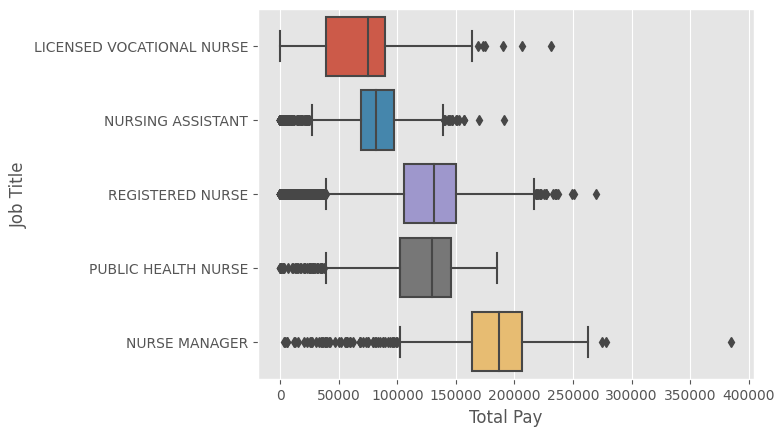

In [21]:
sns.boxplot(x='Total Pay', y='Job Title', data=data);

/Users/pornpanthongdee/.pyenv/versions/3.8.13/envs/lewagon2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


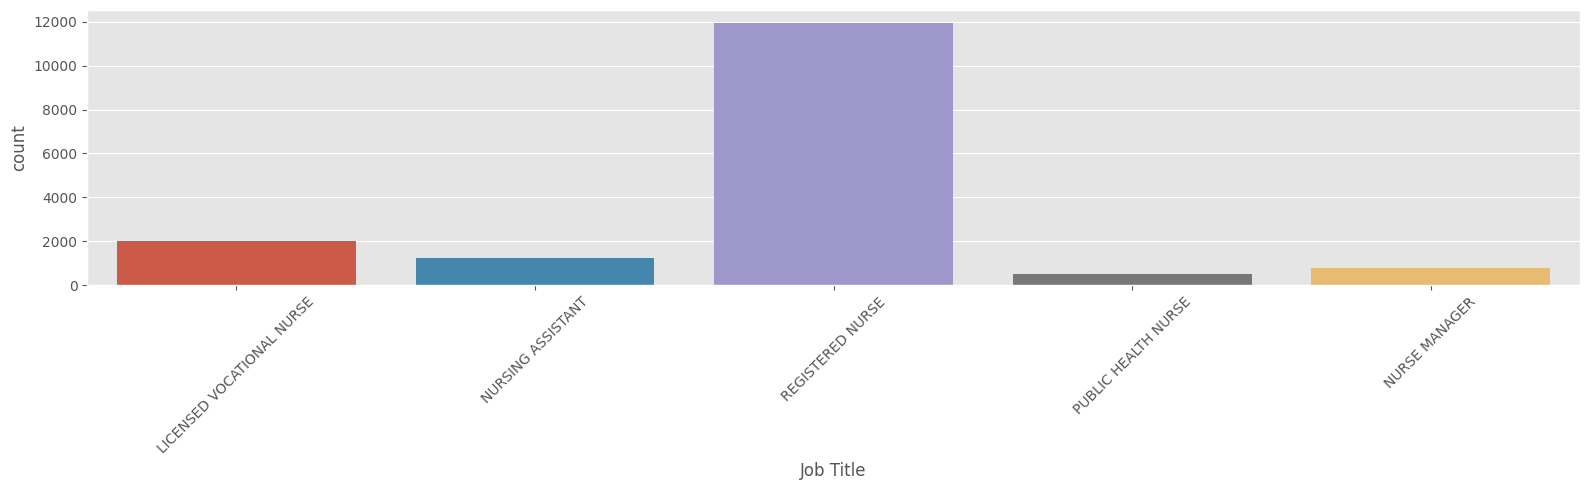

In [22]:
plt.figure(figsize=(16,5))
sns.countplot('Job Title', data = data)
plt.xticks(rotation = 45)
plt.tight_layout();

/Users/pornpanthongdee/.pyenv/versions/3.8.13/envs/lewagon2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


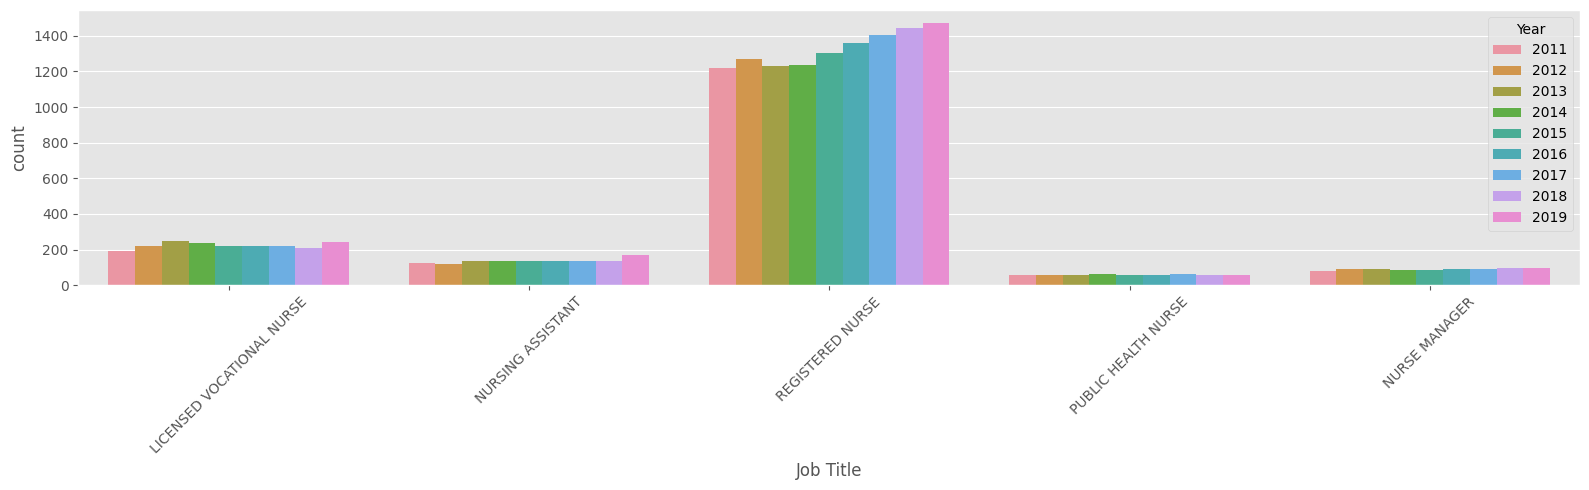

In [23]:
plt.figure(figsize=(16,5))
sns.countplot('Job Title', data = data, hue = 'Year')
plt.xticks(rotation = 45)
plt.tight_layout()

In [24]:
merge_df.columns

Index(['Employee Name', 'Job Title', 'Status', 'Start Salary', 'Start Year',
       'End Salary', 'End Year', 'Total Year', 'Increase Percentage'],
      dtype='object')

# Adding Carrer Level & Type

In [25]:
merge_df['Job Title'].value_counts()

REGISTERED NURSE             8623
LICENSED VOCATIONAL NURSE    1419
NURSING ASSISTANT             882
NURSE MANAGER                 609
PUBLIC HEALTH NURSE           380
Name: Job Title, dtype: int64

In [26]:
merge_df.columns

Index(['Employee Name', 'Job Title', 'Status', 'Start Salary', 'Start Year',
       'End Salary', 'End Year', 'Total Year', 'Increase Percentage'],
      dtype='object')

In [27]:
main_df=merge_df[[ 'Total Year', 'Increase Percentage','Start Salary','End Salary', 'Job Title']]
main_df

,Total Year,Increase Percentage,Start Salary,End Salary,Job Title
0,1,-28.62,121348.48,86623.20,REGISTERED NURSE
1,1,63.32,106385.49,173747.94,REGISTERED NURSE
2,1,175.71,54164.61,149338.07,REGISTERED NURSE
3,2,202.01,54164.61,163583.77,REGISTERED NURSE
4,3,221.49,54164.61,174131.10,REGISTERED NURSE
...,...,...,...,...,...
11908,3,-2.93,107608.78,104456.45,NURSING ASSISTANT
11909,4,1.13,107608.78,108824.77,NURSING ASSISTANT
11910,5,15.70,107608.78,124500.40,NURSING ASSISTANT
11911,6,-26.58,107608.78,79010.87,NURSING ASSISTANT


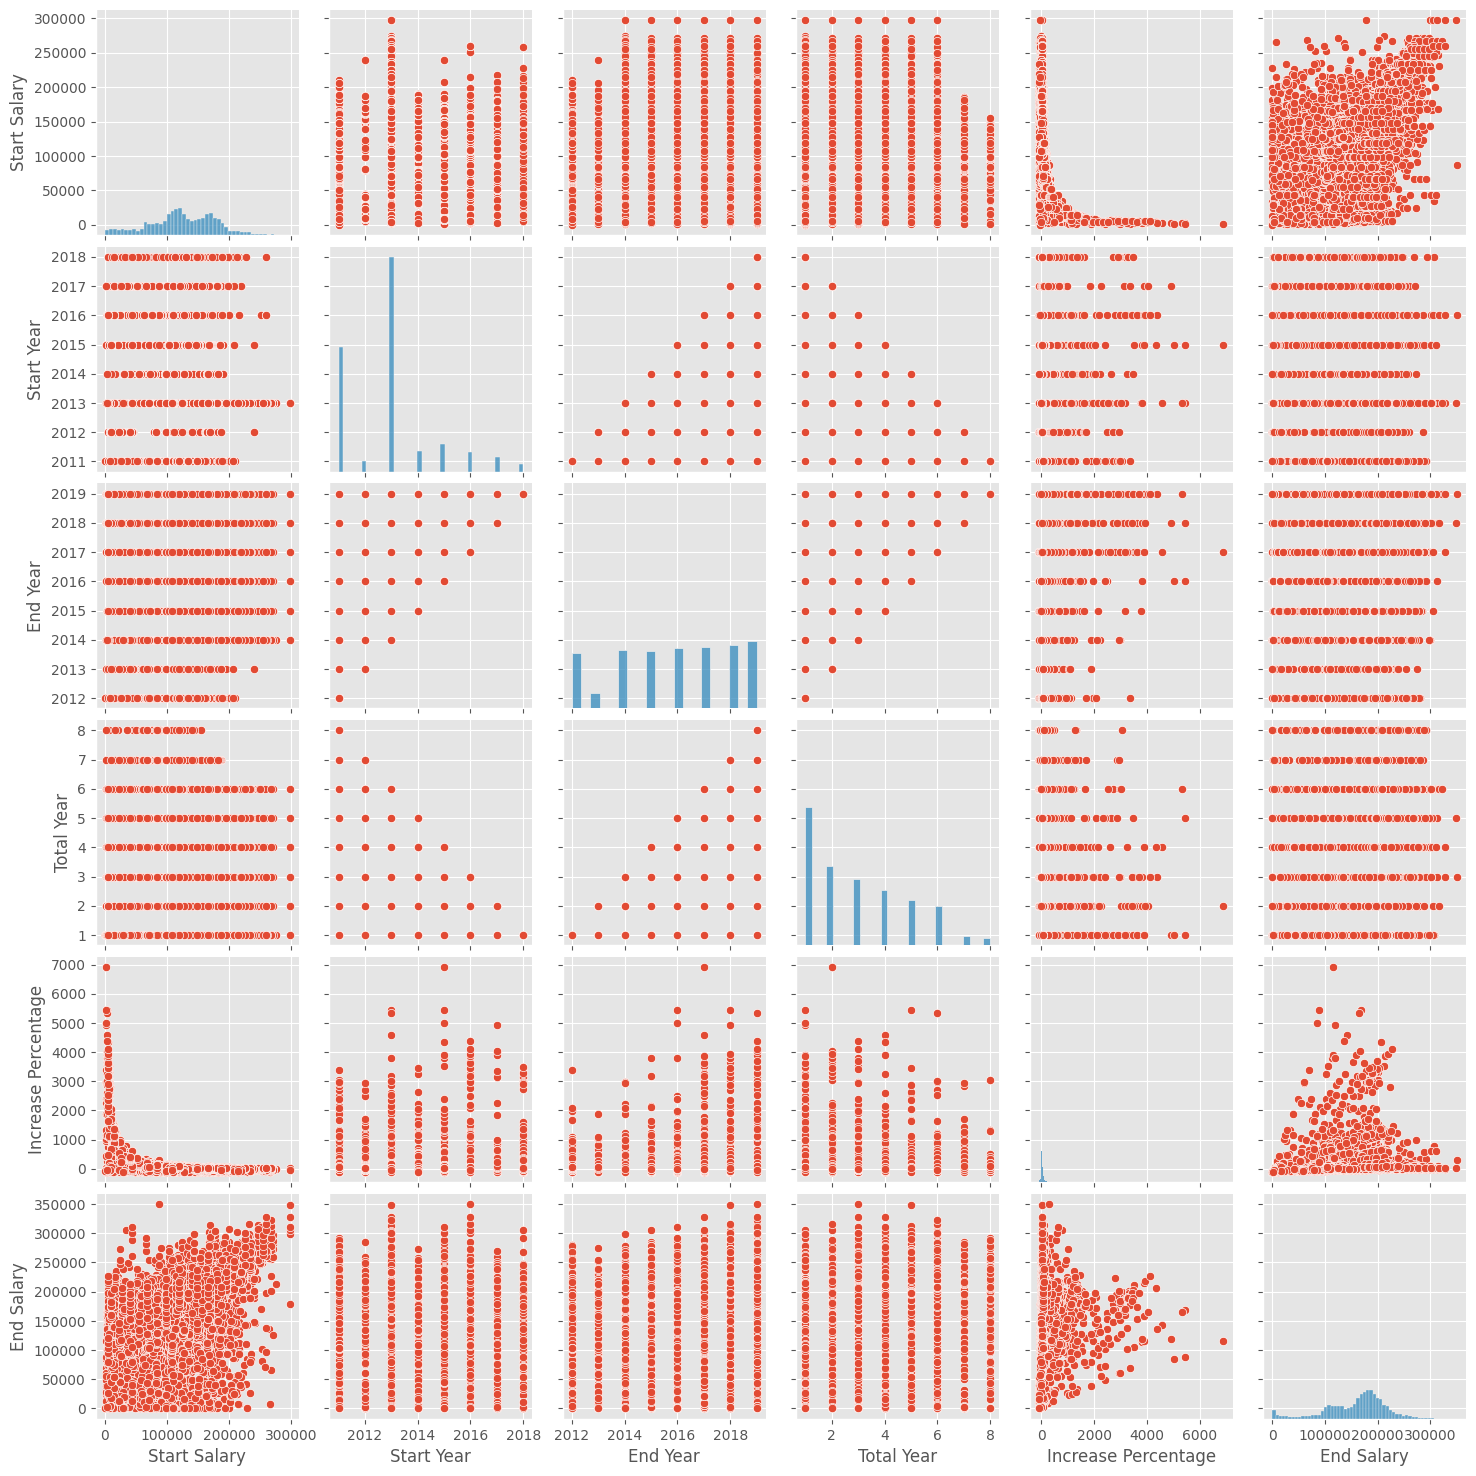

In [28]:
numeric_cols = ['Start Salary', 'Start Year', 'End Year', 'Total Year', 'Increase Percentage','End Salary']
sns.pairplot(merge_df[numeric_cols]);

/var/folders/74/zq1vl5mj4518hvqv44mrtkd80000gn/T/ipykernel_9653/1721136526.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merge_df.corr(), annot=True, cmap='Oranges');


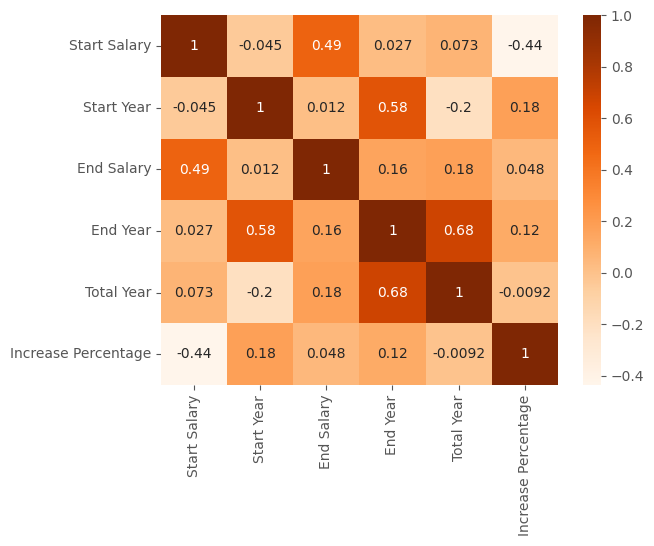

In [29]:
# merge_df.corr()

sns.heatmap(merge_df.corr(), annot=True, cmap='Oranges');

In [30]:
main_df=main_df[main_df['Total Year']>2]

In [31]:
main_df=main_df[main_df['End Salary']>50000]
main_df

,Total Year,Increase Percentage,Start Salary,End Salary,Job Title
4,3,221.49,54164.61,174131.10,REGISTERED NURSE
5,4,234.71,54164.61,181294.57,REGISTERED NURSE
8,3,14.09,174662.29,199263.54,REGISTERED NURSE
9,4,1.44,174662.29,177170.85,REGISTERED NURSE
11,6,-28.02,174662.29,125716.11,REGISTERED NURSE
...,...,...,...,...,...
11904,8,100.86,119085.50,239190.56,REGISTERED NURSE
11908,3,-2.93,107608.78,104456.45,NURSING ASSISTANT
11909,4,1.13,107608.78,108824.77,NURSING ASSISTANT
11910,5,15.70,107608.78,124500.40,NURSING ASSISTANT


In [32]:
main_df.columns=[ 'Total_Year', 'Increase_Percentage','Start_Salary',  'End_Salary','Job Title']
main_df.columns

Index(['Total_Year', 'Increase_Percentage', 'Start_Salary', 'End_Salary',
       'Job Title'],
      dtype='object')

In [33]:
df_testing=main_df[['Total_Year','Start_Salary','Job Title']]
df_testing

,Total_Year,Start_Salary,Job Title
4,3,54164.61,REGISTERED NURSE
5,4,54164.61,REGISTERED NURSE
8,3,174662.29,REGISTERED NURSE
9,4,174662.29,REGISTERED NURSE
11,6,174662.29,REGISTERED NURSE
...,...,...,...
11904,8,119085.50,REGISTERED NURSE
11908,3,107608.78,NURSING ASSISTANT
11909,4,107608.78,NURSING ASSISTANT
11910,5,107608.78,NURSING ASSISTANT


In [34]:
# df_testing.drop_duplicates(subset=['Total_Year','Start_Salary','Job Title'],inplace=True)
# df_testing

## Model with Start Salary + Encoding

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder #one hot encoder

In [36]:
encoder = OneHotEncoder(sparse=False)

In [37]:
tr=encoder.fit_transform(main_df[['Job Title']])
for idx in range(len(encoder.categories_)):
    main_df[encoder.categories_[idx]]=tr[idx]

In [38]:
main_df

,Total_Year,Increase_Percentage,Start_Salary,End_Salary,Job Title,LICENSED VOCATIONAL NURSE,NURSE MANAGER,NURSING ASSISTANT,PUBLIC HEALTH NURSE,REGISTERED NURSE
4,3,221.49,54164.61,174131.10,REGISTERED NURSE,0.0,0.0,0.0,0.0,1.0
5,4,234.71,54164.61,181294.57,REGISTERED NURSE,0.0,0.0,0.0,0.0,1.0
8,3,14.09,174662.29,199263.54,REGISTERED NURSE,0.0,0.0,0.0,0.0,1.0
9,4,1.44,174662.29,177170.85,REGISTERED NURSE,0.0,0.0,0.0,0.0,1.0
11,6,-28.02,174662.29,125716.11,REGISTERED NURSE,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
11904,8,100.86,119085.50,239190.56,REGISTERED NURSE,0.0,0.0,0.0,0.0,1.0
11908,3,-2.93,107608.78,104456.45,NURSING ASSISTANT,0.0,0.0,0.0,0.0,1.0
11909,4,1.13,107608.78,108824.77,NURSING ASSISTANT,0.0,0.0,0.0,0.0,1.0
11910,5,15.70,107608.78,124500.40,NURSING ASSISTANT,0.0,0.0,0.0,0.0,1.0


In [39]:
y = main_df['End_Salary']
y_log = np.log(y)

In [40]:
# X=main_df[['Total_Year','Start_Salary']]

X = main_df.drop(['End_Salary','Job Title','Increase_Percentage'],axis=1)

In [41]:
y_log 

4        12.067564
5        12.107878
8        12.202384
9        12.084870
11       11.741782
           ...    
11904    12.385016
11908    11.556526
11909    11.597494
11910    11.732064
11911    11.277341
Name: End_Salary, Length: 5687, dtype: float64

In [42]:
lrmodel = LinearRegression()

In [43]:
X_train, X_test, y_train, y_test, job_train, job_test = train_test_split(X , y_log, main_df['Job Title'], test_size=0.25,random_state=101)

In [44]:
lrmodel.fit(X_train,y_train)

LinearRegression()

In [45]:
prediction = lrmodel.predict(X_test)
pred_df = pd.DataFrame({'true':y_test, 'pred':prediction, 'job':job_test})
pred_df

,true,pred,job
1034,12.278788,12.194800,REGISTERED NURSE
1706,11.253900,11.977300,LICENSED VOCATIONAL NURSE
2276,11.064961,11.896969,REGISTERED NURSE
10245,11.969634,11.897436,REGISTERED NURSE
4724,12.065619,11.971819,REGISTERED NURSE
...,...,...,...
1371,12.189016,11.980961,REGISTERED NURSE
10001,11.829199,12.342752,NURSE MANAGER
7817,12.422546,12.260855,REGISTERED NURSE
4631,12.422584,12.276392,REGISTERED NURSE


In [46]:
mse = mean_squared_error(y_test,prediction)

In [47]:
mae = mean_absolute_error(y_test,prediction)

In [48]:
rmse = sqrt(mse)

In [49]:
r2Score = r2_score(y_test,prediction)

In [50]:
print("Linear R-egression")
print("Mean Square Error:",mse,"\nRoot mean Square Error:",rmse,"\nMean Absolute Error",mae,"\nR sq value:",r2Score)

Linear R-egression
Mean Square Error: 0.07448023290534841 
Root mean Square Error: 0.2729106683611845 
Mean Absolute Error 0.20012006286480713 
R sq value: 0.2466560855828288


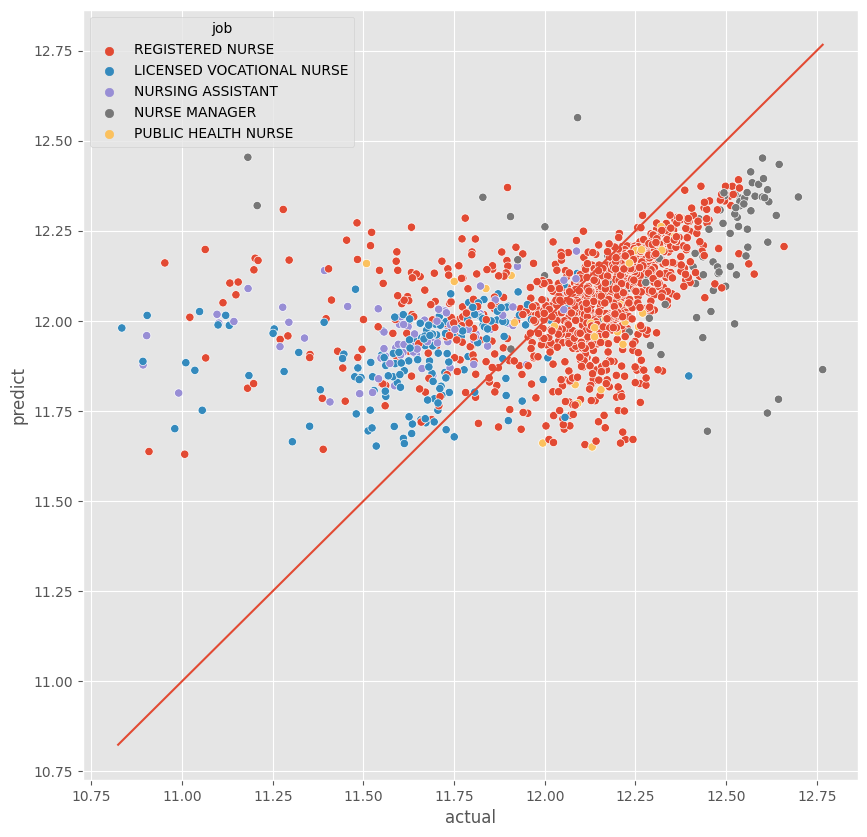

In [81]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="true", y='pred', hue='job', data=pred_df)
plt.ylabel('predict')
plt.xlabel('actual')
plt.plot([min(y_log),max(y_log)], [min(y_log),max(y_log)])

In [52]:
y_test.sort_values()

7503     10.833697
7173     10.891902
3598     10.892371
3525     10.902248
2497     10.903589
           ...    
10820    12.644355
2654     12.646248
4802     12.659695
10501    12.699125
10420    12.766163
Name: End_Salary, Length: 1422, dtype: float64

/Users/pornpanthongdee/.pyenv/versions/3.8.13/envs/lewagon2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'predict')

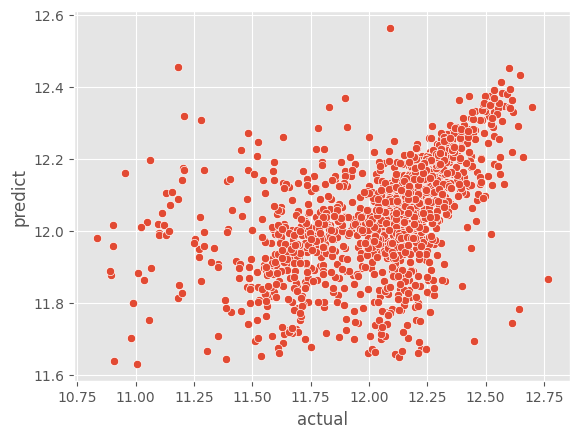

In [53]:
sns.scatterplot(y_test, prediction)
plt.xlabel('actual')
plt.ylabel('predict')

In [54]:
X_test

,Total_Year,Start_Salary,LICENSED VOCATIONAL NURSE,NURSE MANAGER,NURSING ASSISTANT,PUBLIC HEALTH NURSE,REGISTERED NURSE
1034,3,205626.38,0.0,0.0,0.0,0.0,1.0
1706,6,85873.61,0.0,0.0,0.0,0.0,1.0
2276,6,56923.00,0.0,0.0,0.0,0.0,1.0
10245,3,98458.02,0.0,0.0,0.0,0.0,1.0
4724,3,125265.14,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
1371,3,128559.87,0.0,0.0,0.0,0.0,1.0
10001,3,258947.34,0.0,0.0,0.0,0.0,1.0
7817,4,215643.31,0.0,0.0,0.0,0.0,1.0
4631,6,193664.95,0.0,0.0,0.0,0.0,1.0


In [55]:
#https://www.incrediblehealth.com/salaries/rn/ca/san-francisco

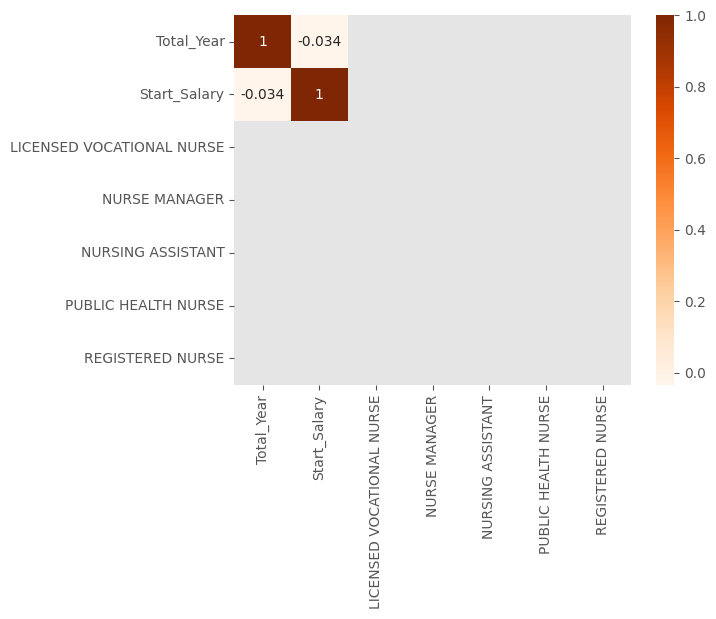

In [56]:
sns.heatmap(X.corr(), annot=True, cmap='Oranges');

## Random

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [58]:
rf = RandomForestRegressor()

In [59]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [60]:
grid_parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [61]:
rf_grid_search = RandomizedSearchCV(rf,param_distributions=grid_parameters,cv=2,random_state=43)

In [62]:
rf_grid_search.fit(X_train,y_train)

/Users/pornpanthongdee/.pyenv/versions/3.8.13/envs/lewagon2/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/pornpanthongdee/.pyenv/versions/3.8.13/envs/lewagon2/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/pornpanthongdee/.pyenv/versions/3.8.13/envs/lewagon2/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. T

RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=43)

In [63]:
rf_grid_search.best_params_

{'n_estimators': 900,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [64]:
rf_prediction = rf_grid_search.predict(X_test)

In [65]:
mse = mean_squared_error(y_test,rf_prediction)

In [66]:
mae = mean_absolute_error(y_test,rf_prediction)

In [67]:
rmse = sqrt(mse)

In [68]:
r2Score = r2_score(y_test,rf_prediction)

In [69]:
print("Random Forest Regression")
print("Mean Square Error:",mse,"\nRoot mean Square Error:",rmse,"\nMean Absolute Error",mae,"\nR sq value:",r2Score)

Random Forest Regression
Mean Square Error: 0.0794940672848076 
Root mean Square Error: 0.2819469228149291 
Mean Absolute Error 0.20010271014699305 
R sq value: 0.19594274231950604


Text(0, 0.5, 'residual')

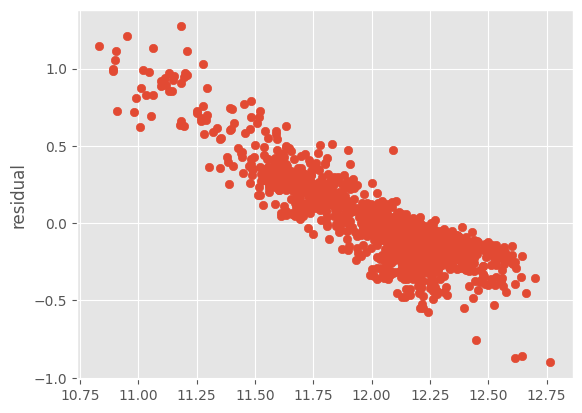

In [70]:
residual = prediction - y_test
plt.scatter(y_test, residual)
plt.ylabel('residual')

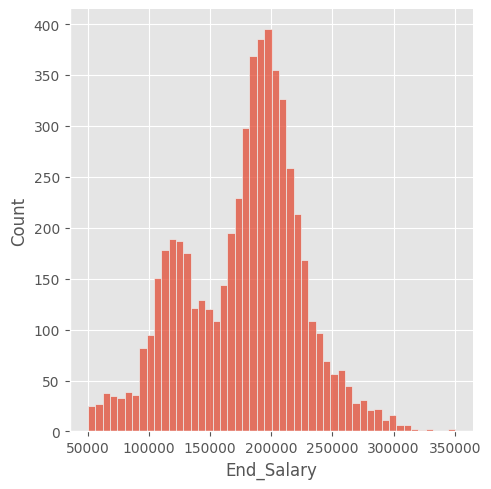

In [71]:
sns.displot(y, bins=50);

In [72]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')


In [73]:
main_df.columns

Index(['Total_Year', 'Increase_Percentage', 'Start_Salary', 'End_Salary',
       'Job Title', 'LICENSED VOCATIONAL NURSE', 'NURSE MANAGER',
       'NURSING ASSISTANT', 'PUBLIC HEALTH NURSE', 'REGISTERED NURSE'],
      dtype='object')

In [78]:
knn_data =main_df['End_Salary']

In [79]:
# Let's make some blobs to test KMeans on...
knn_data, color = make_blobs(n_samples=100, random_state=42, centers=3, 
                         cluster_std=1.5)

In [88]:
df = pd.DataFrame(data, columns=['x1', 'x2'])
df.head()

,x1,x2
0,-8.149818,-9.152380
1,5.860155,0.126873
2,-3.213409,9.828126
3,6.744070,-0.129607
4,-6.342946,-6.038933


In [ ]:
# Take a look at the data using a scatterplot
df.plot(kind="scatter", x="x1", y="x2", figsize=(12,6), s=50)
plt.xlabel("$X_1$", fontsize=18)
plt.ylabel("$X_2$", fontsize=18);

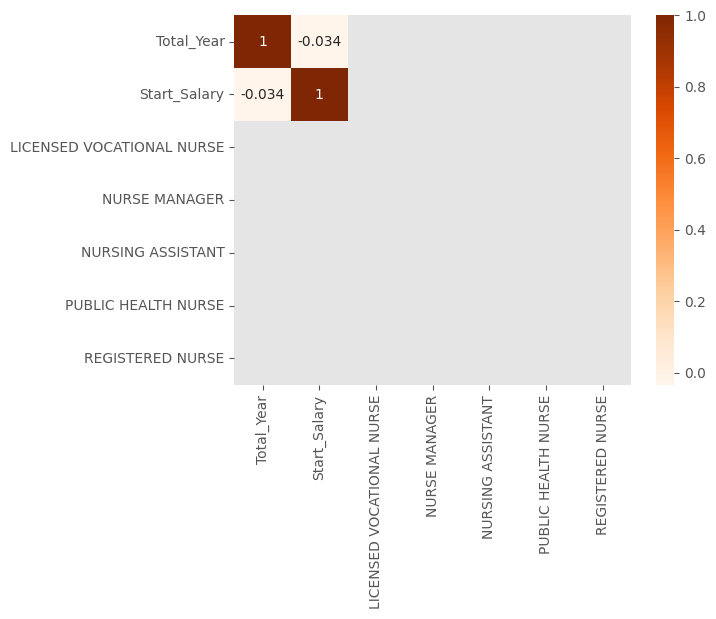

In [73]:
sns.heatmap(X.corr(), annot=True, cmap='Oranges');

## Dummy Regressor

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyRegressor

In [75]:
X = main_df.drop(['End_Salary','Job Title','Increase_Percentage'],axis=1)
X

,Total_Year,Start_Salary,LICENSED VOCATIONAL NURSE,NURSE MANAGER,NURSING ASSISTANT,PUBLIC HEALTH NURSE,REGISTERED NURSE
4,3,54164.61,0.0,0.0,0.0,0.0,1.0
5,4,54164.61,0.0,0.0,0.0,0.0,1.0
8,3,174662.29,0.0,0.0,0.0,0.0,1.0
9,4,174662.29,0.0,0.0,0.0,0.0,1.0
11,6,174662.29,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
11904,8,119085.50,0.0,0.0,0.0,0.0,1.0
11908,3,107608.78,0.0,0.0,0.0,0.0,1.0
11909,4,107608.78,0.0,0.0,0.0,0.0,1.0
11910,5,107608.78,0.0,0.0,0.0,0.0,1.0


In [76]:
y = main_df['End_Salary']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
lm = LinearRegression().fit(X_train, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
  
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)
y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)

In [78]:
print('Linear model, coefficients: ', lm.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (linear model): {:.2f}".format(mean_squared_error(y_test, y_predict)))
  
print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, 
                                                                    y_predict_dummy_median)))
print("Median absolute error (linear model): {:.2f}".format(median_absolute_error(y_test, y_predict)))
  
print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_predict)))

Linear model, coefficients:  [6.87444621e+03 4.83167962e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Mean squared error (dummy): 2294426349.09
Mean squared error (linear model): 1641730588.98
Median absolute error (dummy): 28927.98
Median absolute error (linear model): 24412.45
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.04
r2_score (linear model): 0.28
